# Figures 1 and 2

Generate figures matching theory and simulation of the propagation of norms and inner products in a random deep neural network.

## Setup

In [40]:
%pylab inline
%load_ext autoreload
%autoreload 2

from __future__ import print_function
import os, sys
from tqdm import tqdm

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.unicode'] = True
plt.rcParams['image.cmap'] = 'viridis'

# Add cornet and Theano to path
sys.path.insert(0, '../')
sys.path.insert(0, '/home/poole/Theano_clean')

# Output figure directory
figure_dir = "../writeup/figures"
results_dir = "../results"
if not os.path.exists(figure_dir):
    raise ValueError("Figure directory does not exist. Create it or change figure_dir above.")
if not os.path.exists(results_dir):
    raise ValueError("Results directory does not exist. Create it or change results_dir above.")

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


`%matplotlib` prevents importing * from pylab and numpy


## Parameters

Choice of nonlinearity, along with its first and second derivatives:

In [4]:
from scipy.stats import hypsecant
def sech(x):
    return hypsecant.pdf(x) * np.pi

phi = np.tanh
dphi = lambda x: sech(x)**2
d2phi = lambda x: 2 * (np.tanh(x)**3 - np.tanh(x))

Import useful constants, including the range for $\sigma_w$ and $\sigma_b$:

In [5]:
from cornet.constants import *
print("Weight sigmas (n=%d):" % nw, weight_sigmas)
print("Bias sigmas (n=%d):" % nb, bias_sigmas)

Weight sigmas (n=41): [ 1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4
  2.5  2.6  2.7  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9
  4.   4.1  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5. ]
Bias sigmas (n=41): [ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4
  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8  2.9
  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4. ]


## Theory for squared length map, $\mathcal{V}(q^{l-1} | \sigma_w, \sigma_b)$

Compute fixed points, dynamics, and convergence of the $q$ map.

Note: This could be sped up a bunch...

In [6]:
from cornet.theory import qmap, q_fixed_point

In [7]:
# Range of squared lengths for q map plot (panel A)
nq = 100
qmax = 15
qrange = np.linspace(0, qmax, nq)

# Number of iterations for the dynamics of convergence plot (panel B)
nt = 20

# Maximum number of iterations when computing convergence time (panel D)
nconverge = 25

qconverge = np.linspace(0, qmax, nconverge)
qmaps = np.zeros((nw, nb, nq, nt))
qstars = np.zeros((nw, nb))
tstars = np.zeros((nw, nb, nconverge))
qmaps[..., 0] = qrange[None, None, None, :]

for widx, weight_sigma in enumerate(tqdm(weight_sigmas)):
    for bidx, bias_sigma in enumerate(bias_sigmas):
        # Compute fixed points
        _, qstars[widx, bidx]  =  q_fixed_point(weight_sigma, bias_sigma, nonlinearity, qinit=3.0, tol_frac=0.01)
        # Iterate over initial norms, computing convergence time
        for tidx, qinit in enumerate(qconverge):
            tstars[widx, bidx, tidx], _  =  q_fixed_point(weight_sigma, bias_sigma, nonlinearity, qinit=qinit, tol_frac=0.01)
        # Dynamics of convergence of q map
        for t in xrange(1, nt):
            qmaps[widx, bidx, :, t] = qmap(qmaps[widx, bidx, :, t - 1], weight_sigma, bias_sigma, nonlinearity)       

100%|██████████| 41/41 [02:15<00:00,  3.00s/it]


## Simulations for squared length in a random neural network

Create a feedforward fully-connected neural network. Note that here we flip the order of activations and linear layers so that the first operation is the activaiton function.

In [8]:
from cornet.net import RandNet
n_hidden_layers = 1
n_hidden_units = 1000
din = 1000
# Flip flag here chooses whether activations or linear layer is first
net = RandNet(din, n_hidden_units, n_hidden_layers, nonlinearity=nonlinearity, flip=True)

Using Theano backend.


### Simulate a single layer at a large number of input norms (for panel A)

In [9]:
npnts = 20
qmap_sim = np.zeros((nw, nb, nq, npnts))
for widx, weight_sigma in enumerate(tqdm(weight_sigmas)):
    for bidx, bias_sigma in enumerate(bias_sigmas):
        net.randomize(bias_sigma=bias_sigma, weight_sigma=weight_sigma)
        for norm_idx, qnorm in enumerate(qrange):
            xs = np.random.randn(npnts, din) *  np.sqrt(qnorm)
            h = net.get_act(xs)
            qmap_sim[widx, bidx,norm_idx] = 1.0 / din * (h**2).sum(-1)

100%|██████████| 41/41 [05:02<00:00,  7.38s/it]


### Simulate multiple layers at a small set of points (for dynamics in panel B)

TODO: use different random matrices at each layer

In [10]:
qidx = [26, 53, 80]
qnorms = qrange[qidx]
nqnorms = len(qnorms)

#hout = net.get_act(xs)
nlayers = 7
qmaps_sim = np.zeros((nw, nb, nqnorms, nlayers, nq))
for widx, weight_sigma in enumerate(tqdm(weight_sigmas)):
    for bidx, bias_sigma in enumerate(bias_sigmas):
        net.randomize(bias_sigma=bias_sigma, weight_sigma=weight_sigma)
        for norm_idx, qnorm in enumerate(qnorms):
            xs = np.random.randn(nq, din) *  np.sqrt(qnorm)
            qmaps_sim[widx, bidx,norm_idx, 0] = 1.0 / din * (xs**2).sum(-1)
            for lidx in xrange(1, nlayers):
                #XXX: use different weight matrices for each layer, very slow but similar results
                #net.randomize(bias_sigma=bias_sigma, weight_sigma=weight_sigma)

                xs = net.get_act(xs)
                qmaps_sim[widx, bidx, norm_idx, lidx] = 1.0 / din * (xs**2).sum(-1)

100%|██████████| 41/41 [02:06<00:00,  3.09s/it]


Some useful plotting functions:

In [11]:
from cornet.viz import get_pal, add_label, pcolor, sigma_pcolor
def plot_qmaps(qrange, qmaps, widxs, bidxs, vmax=15, **plot_kwargs):
    for ii, (widx, bidx) in enumerate(zip(widxs, bidxs)):
        if qmaps.ndim == 4:
            for qidx in xrange(qmaps.shape[-2]):
                plot(qrange, qmaps[widx, bidx, qidx], **plot_kwargs)
        else:
            plot(qrange, qmaps[widx, bidx], **plot_kwargs)
    vmax = 15
    xticks([0, 5, 10, 15])
    yticks([0, 5, 10, 15])
    xlim(0, vmax); ylim(0, vmax)
    xlabel('input length ($q^{l-1})$')
    ylabel('output length ($q^l$)')

# Figure 1:  Dynamics of the squared length $q^l$
(A) The iterative length map for 3 different $\sigma_w$ at $\sigma_b=0.3$. Theoretical predictions (solid lines) match well with individual network simulations (dots). Stars reflect fixed points $q^*$ of the map. (B) The iterative dynamics of the length map yields rapid convergence of $q^l$ to  $q^*$ , independent of initial condition (lines=theory; dots=simulation).  (C) $q^*$ as a function of $\sigma_w$ and $\sigma_b$. (D) Number of iterations required to achieve $\leq$ 1% fractional deviation off the fixed point.  The $(\sigma_b,\sigma_w)$ pairs in (A,B) are marked with color matched circles in (C,D).

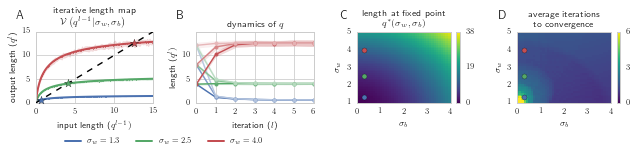

In [12]:
figure(figsize=(9, 2))
gs = GridSpec(1, 4)
qmax_plot = 15
tmax = 6
p1 = get_pal(len(widxs), 1)
p2 = get_pal(len(widxs), 1)
sns.set_palette(np.vstack((p1, p2)))

# Panel A - qmap
subplot(gs[0, 0])
plot_qmaps(qrange, qmaps[..., 1], widxs, bidxs, lw=2)
plot_qmaps(qrange, qmap_sim[..., :].mean(-1), widxs, bidxs, marker='o', ls='none', markersize=1, alpha=0.9, zorder=0)
for ii, (widx, bidx) in enumerate(zip(widxs, bidxs)):
    mu = qmap_sim[widx,bidx ,:, : ].mean(-1)
    std = qmap_sim[widx, bidx,:, : ].std(-1)
    fill_between(qrange, mu-std, mu+std, alpha=0.2, label='_nolegend_', color=p1[ii])

# Add unity line
plot((0, qmax), (0, qmax), '--', color='k', zorder=900)
for i, (widx, bidx) in enumerate(zip(widxs, bidxs)):
    scatter(qstars[widx, bidx], qstars[widx, bidx], s=75, marker= '*', c=p1[i], zorder=999, alpha=1.0, clip_on=False)
ylim(0, qmax_plot)
add_label('A')
title(r'iterative length map\\$\phantom\qquad\phantom\;\mathcal{V}\left(q^{l-1} \vert \sigma_w, \sigma_b\right)$')
lgd = legend(['$\sigma_w=%.1f$'%weight_sigmas[widx] for widx in widxs], bbox_to_anchor=(2.0, -.4), fancybox=False, frameon=False, ncol=len(widxs))


# Panel B - dynamics of convergence
pal = get_pal(len(widxs), len(qidx))
subplot(gs[0, 1])
xx = np.arange(nlayers)
for i in xrange(3):          
    for pidx, (widx, bidx) in enumerate(zip(widxs, bidxs)):
        if i == 1:
            plot(qmaps[widx, bidx, qidx, :].T, '-', markersize=3, alpha=1.0)       
        elif i==0:
            mu = qmaps_sim[widx,bidx ,:, : ].mean(-1)
            std = qmaps_sim[widx, bidx,:, : ].std(-1)
            for j in xrange(mu.shape[0]):
                fill_between(xx, mu[j]-std[j], mu[j]+std[j], alpha=0.2, label='_nolegend_', color=pal[pidx*mu.shape[0]+j])
        elif i == 2:
            mu = qmaps_sim[widx,bidx ,:, : ].mean(-1)
            plot(xx, mu.T, 'o', markersize=4, label='_nolegend_', alpha=0.9)


xlabel('iteration ($l$)')
ylabel('length ($q^{l})$')
title('dynamics of $q$')
yticks([0, 5, 10])
ylim(0, qmax)
xlim(0, tmax)
add_label('B')


# Panel C - q*
subplot(gs[0, 2])
sigma_pcolor(qstars, weight_sigmas, bias_sigmas)
title('length at fixed point\n$q^*(\sigma_w, \sigma_b)$')
add_label('C')
# add dots for lines from panel A
p1 = get_pal(len(widxs), 1)
for i, (widx, bidx) in enumerate(zip(widxs, bidxs)):
    scatter(bias_sigmas[bidx], weight_sigmas[widx], s=25, marker= 'o', c=p1[i])
xlim(0, bmax); ylim(1, wmax)


# Panel D - time to convergence
subplot(gs[0, 3])
sigma_pcolor(tstars.mean(-1), weight_sigmas, bias_sigmas, vmax=tmax)
xlim(0, bmax); ylim(1, wmax)
# add dots for lines from panel A
p1 = get_pal(len(widxs), 1)
for i, (widx, bidx) in enumerate(zip(widxs, bidxs)):
    scatter(bias_sigmas[bidx], weight_sigmas[widx], s=25, marker= 'o', c=p1[i])
title('average iterations\nto convergence')
add_label('D')

gcf().tight_layout()
savefig(os.path.join(figure_dir, "fig1_qmap.pdf" ), bbox_extra_artists=(lgd,), bbox_inches='tight')

## Theory for covariance propagation and curvature

### Covariance propagation

In [ ]:
from cornet.theory import covmap

In [ ]:
nq = 51
c12s = np.linspace(0, 1.0, nq)
crange = c12s

In [17]:
cmaps = np.zeros((nw, nb, nq))
cstars = np.zeros((nw, nb))
for widx, weight_sigma in enumerate(tqdm(weight_sigmas)):
    for bidx, bias_sigma in enumerate(bias_sigmas):
        #q_fixed_points[widx, bidx] = q_fixed_point(weight_sigma, bias_sigma, nonlinearity, fast=True)
        q1 = qstars[widx, bidx]
        cin = (c12s * q1)
        cout = covmap(q1, q1,  cin, weight_sigma, bias_sigma, nonlinearity)
        cmaps[widx, bidx, :] = cout
        # Remove  fixed point at cin = q*
        cstar = cin[np.argmin(np.abs(cin[:-1] - cout[:-1]))]
        cstars[widx, bidx] = cstar
        
cstars_unnormalized = cstars.copy()
cstars /= qstars

cmaps_unnormalized = cmaps.copy()
cmaps /= qstars[:, :, None]

100%|██████████| 41/41 [08:14<00:00, 10.60s/it]


In [18]:
save_data = False
load_data = False
qcmap_fn = os.path.join(results_dir, "q_c_maps.npz")
if save_data:
    np.savez(qcmap_fn, weight_sigmas=weight_sigmas, bias_sigmas=bias_sigmas, cstars=cstars, qstars=qstars, cmaps=cmaps, qmaps=qmaps)
if load_data:
    f = np.load(qcmap_fn)
    locals().update({k:f[k] for k in f.keys()})

### Covariance dynamics for subset of points

In [22]:
cin = crange_traj = np.array([0.2, 0.5, 0.8])
nctraj = len(cin)
nt = 31
ctrajs = np.zeros((len(widxs), nctraj, nt))
for i, (widx, bidx) in enumerate(tqdm(zip(widxs, bidxs))):
    q1 = qstars[widx, bidx]
    ctrajs[i, :, 0] = cin * q1
    for t in xrange(1, nt):
        ctrajs[i, :, t] = covmap(q1, q1, ctrajs[i, :, t-1], weight_sigmas[widx], bias_sigmas[bidx], nonlinearity)
    ctrajs[i] /= q1
ctrajs_ = ctrajs.copy()
ctrajs = np.zeros((nw, nb, nctraj, nt))
for i, (widx, bidx) in enumerate(zip(widxs, bidxs)):
    ctrajs[widx, bidx] = ctrajs_[i]

100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


### Theory for curvature propagation

In [28]:
from cornet.theory import compute_chi1, compute_chi2, kappa_map

In [29]:
chi1 = np.zeros((nw, nb))
chi2 = np.zeros((nw, nb))
q_fixed_points = np.zeros((nw, nb))
n_layers = 31 # only plot up to layer 30 in panel 2B
kappas = np.zeros((nw, nb, n_layers))
g2s = np.zeros((nw, nb, n_layers))

for widx, weight_sigma in enumerate(tqdm(weight_sigmas)):
    for bidx, bias_sigma in enumerate(bias_sigmas):
        _, q_fixed_points[widx, bidx] = q_fixed_point(weight_sigma, bias_sigma, nonlinearity, fast=True)

        g0 =  q_fixed_points[widx, bidx]# / din
        kappa0 =  1./((q_fixed_points[widx, bidx]) * din)
        g2s[widx, bidx, 0] = g0
        kappas[widx, bidx] = kappa0
        chi1[widx, bidx] = compute_chi1(q_fixed_points[widx, bidx], weight_sigma, bias_sigma, dphi)
        chi2[widx, bidx] = compute_chi2(q_fixed_points[widx, bidx], weight_sigma, bias_sigma, d2phi, hidden_units=n_hidden_units)
        for lidx in xrange(1, n_layers):
            kappas[widx, bidx, lidx] = kappa_map(kappas[widx, bidx, lidx  -1], chi1[widx, bidx], chi2[widx, bidx])
            g2s[widx, bidx, lidx] = chi1[widx, bidx] * g2s[widx, bidx, lidx -1]

100%|██████████| 41/41 [01:54<00:00,  3.31s/it]


# Figure 2: Dynamics of correlations, $c_{12}^l$, in a tanh network
(A) The $\mathcal C$-map for the same $\sigma_w$ and $\sigma_b$ as in Figure 1A. (B) The $\mathcal C$-map dynamics, derived from both theory and numerical simulations with $N_l = 1000$ (dots) (C) Fixed points $c^*$ of the $\mathcal C$-map.  (D)  The slope of the $\mathcal C$-map at $1$, $\chi_1$, partitions the space (black dotted line at $\chi_1=1$) into chaotic ($\chi_1 > 1$) and ordered ($\chi_1 < 1$) regions.

In [38]:
# Generated in Figures 3 & 4 notebook
autocorr_data_fn = os.path.join(results_dir, "autocorr.npz")
if not os.path.exists(autocorr_data_fn):
    print("Warning: simulations for the dynamics of the correlation map not found. Simulations will not be plotted."
          "Run Figure 3/4 notebook first to generate data.")
else:
    f = np.load(autocorr_data_fn)
    acorr_mu = f['acorr_mu'].squeeze()
    acorr_std = f['acorr_std'].squeeze()
    acorr_ts = f['ts']

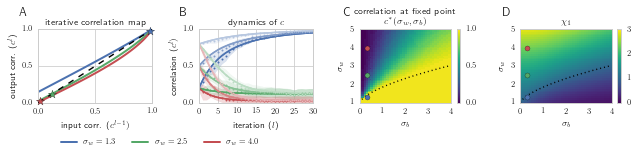

In [39]:
figure(figsize=(9, 2))
gs = GridSpec(1, 4)
qmax_plot = 15
tmax = 6
p1 = get_pal(len(widxs), 1)
p2 = get_pal(len(widxs), 1)
sns.set_palette(np.vstack((p1, p2)))


# Panel A - qmap
ax = subplot(gs[0, 0])
#sns.palplot(sns.)
plot_qmaps(crange, cmaps, widxs, bidxs, lw=2)
#plot_qmaps(qrange, qmaps_sim[..., :], widxs, bidxs, marker='o', ls='none', markersize=3, alpha=0.5, zorder=0)
xticks([0, 0.5, 1.0])
yticks([0, 0.5, 1.0])
xlabel('input corr. ($c^{l-1})$')
ylabel('output corr.  ($c^{l}$)')
# Add unity line
plot((0, 1), (0, 1), '--', color='k', zorder=900)
xlim(0, 1); ylim(0, 1)
axis('tight')
for i, (widx, bidx) in enumerate(zip(widxs, bidxs)):
    scatter(cstars[widx, bidx], cstars[widx, bidx], s=75, marker= '*', c=p1[i], zorder=999, alpha=1.0, clip_on=False)
    
if 0:
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes
    axins = inset_axes(ax, width="40%", height="40%", loc=2, borderpad=0.3)
    plot_qmaps(crange, cmaps, widxs, bidxs, lw=2)
    plot((0, 1), (0, 1), '--', color='k')
    axins.set_xlim(0.05, 0.3)
    axins.set_ylim(0.05, 0.3)
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
    xlabel(''); ylabel(''); xticks([]); yticks([])
    for i, (widx, bidx) in enumerate(zip(widxs, bidxs)):
        scatter(cstars[widx, bidx], cstars[widx, bidx], s=150, marker= '*', c=p1[i], zorder=999, alpha=0.7)
    sca(ax)
    
add_label('A')
title(r'iterative correlation map')#\\$\phantom\qquad\phantom\;c_{12}^l$')
lgd = legend(['$\sigma_w=%.1f$'%weight_sigmas[widx] for widx in widxs], bbox_to_anchor=(2.0, -.4), fancybox=False, frameon=False, ncol=len(widxs))



# Panel B - dynamics of convergence
qidx = np.arange(ctrajs.shape[2])
pal = get_pal(len(widxs), len(qidx))
#sns.palplot(sns.color_palette());
subplot(gs[0, 1])
xx = np.arange(0, acorr_mu.shape[-1])
for pidx, (widx, bidx) in enumerate(zip(widxs, bidxs)):
    plot(ctrajs[widx, bidx, qidx, :].T, '-', markersize=1.5, alpha=1.0)
    
for i in xrange(3):          
    for pidx, (widx, bidx) in enumerate(zip(widxs, bidxs)):
        # Find indices corresponding to closest starting correlation value
        idx = np.argmin(np.abs(cin[None, :] - acorr_mu[pidx, :, 0][:, None]), axis=0)
        if i == 1:
            plot(ctrajs[widx, bidx, qidx, :].T, '-', markersize=1.5, alpha=1.0)
        elif i==0:
            mu = acorr_mu[pidx, idx, :]
            std = acorr_std[pidx, idx, :]
            for j in xrange(nctraj):
                fill_between(xx, mu[j]-std[j], mu[j]+std[j], alpha=0.2, label='_nolegend_', color=pal[pidx*nctraj+j])

        elif i == 2:
            plot(xx, acorr_mu[pidx, idx, :].T, 'o', markersize=2, label='_nolegend_')

xlabel('iteration ($l$)')
ylabel('correlation ($c^{l})$')
title('dynamics of $c$')
yticks([0, 0.5, 1])
ylim(0, 1)
xlim(0, nt - 1)
add_label('B')


# Panel C - q*
subplot(gs[0, 2])
sigma_pcolor(cstars, weight_sigmas, bias_sigmas)
title('correlation at fixed point\n$c^*(\sigma_w, \sigma_b)$')
add_label('C')
# add chi1=1 contour
cf = contour(bias_sigmas, weight_sigmas, chi1, levels=[1.0],
              cmap=cm.gray, zorder=1, linestyles='dotted')
# add dots for lines from panel A
p1 = get_pal(len(widxs), 1)
for i, (widx, bidx) in enumerate(zip(widxs, bidxs)):
    scatter(bias_sigmas[bidx], weight_sigmas[widx], s=25, marker= 'o', c=p1[i])
xlim(0, bmax); ylim(1, wmax)


# Panel D - time to convergence
ax = subplot(gs[0, 3])
sigma_pcolor(chi1, weight_sigmas, bias_sigmas, draw_colorbar=False)
colorbar(ticks=(0, 1, 2, 3))
cf = contour(bias_sigmas, weight_sigmas, chi1, levels=[1.0],
                  cmap=cm.gray, zorder=1, linestyles='dotted')
xlim(0, bmax); ylim(1, wmax)
# add dots for lines from panel A
p1 = get_pal(len(widxs), 1)
for i, (widx, bidx) in enumerate(zip(widxs, bidxs)):
    scatter(bias_sigmas[bidx], weight_sigmas[widx], s=25, marker= 'o', c=p1[i])
title('$\chi_{1}$')
add_label('D')

#plt.subplots_adjust(wspace=0.4)
gcf().tight_layout()

savefig(os.path.join(figure_dir, "fig2_cmap.pdf" ), bbox_extra_artists=(lgd,), bbox_inches='tight')